In [1]:
import math
import json
import re
import typing

import randomhash
import requests
import matplotlib.pyplot as plt

In [2]:
orwell1984_text = requests.get(
    "http://gutenberg.net.au/ebooks01/0100021.txt"
).content.decode("utf-8-sig")

orwell1984_normalized_text = re.sub(
    "\s+",
    " ",
    re.sub(
        "[^a-zA-Z\s]+",
        "",
        orwell1984_text)).lower()

orwell1984_tokens = orwell1984_normalized_text.split()

In [3]:
mobydick_text = requests.get(
    "https://www.gutenberg.org/files/2701/2701-0.txt"
).content.decode("utf-8-sig")

mobydick_normalized_text = re.sub(
    "\s+",
    " ",
    re.sub(
        "[^a-zA-Z\s]+",
        "",
        mobydick_text)).lower()

mobydick_tokens = mobydick_normalized_text.split()

In [4]:
def compute_windowed_sample(sample_freqs, timestamps, start, window_size):
    
    windowed_sample = dict()
    
    for element, freq in sample_freqs.items():
        
        # fetch timestamp of element
        timestamp = timestamps.get(element)
        if timestamp is None:
            continue
        
        # check if it is in the window
        if timestamp < start or timestamp > (start + window_size):
            continue
        
        windowed_sample[element] = timestamp
    
    return windowed_sample

In [8]:
def affirmative_sampling_with_timestamps(
    tokens: typing.List[str],
    k: int,
    w: int = 10000,
    seed: typing.Optional[int] = None,
) -> typing.Dict[str, typing.Any]:
    """
    Returns a random sample of the stream of tokens ``tokens``, using the
    algorithm "Affirmative Sampling" by Jérémie Lumbroso and Conrado
    Martínez (2022).

    :param tokens: A list of string tokens
    :type tokens: typing.List[str]
    :param k: The parameter of Affirmative Sampling that controls the fixed part of the sample
    :type k: int
    :param w: The size of the window
    :type w: int
    :param seed: A seed for the pseudo-random number generator (optional, time-seeded by default)
    :type seed: typing.Optional[int]

    :return: A dictionary containing a cardinality estimate, as well as a random sample of the stream of tokens
    :rtype: typing.Dict[str, typing.Any]
    """

    # initialize the PRNG
    prng = randomhash.RandomHashFamily(seed=seed)

    # initialize the sample

    sample_core = set()
    sample_xtra = set()
    sample_freqs = {}
    
    # timestamps = numbering from 0 to N of each item
    # timestamp dict (maps items -> most recent "timestamp")
    latest_timestamp = dict()
    windowed_sample_size = [0] * len(tokens)
    windowed_cardinality = [0] * len(tokens)

    # INITIAL PART
    # ============

    # fill S with the first k distinct elements (and hash values)

    idx = 0
    while len(sample_core) < k and idx < len(tokens):
        z = tokens[idx]
        if z not in sample_core:
            sample_core.add(z)
        idx += 1

        # update frequency
        sample_freqs[z] = sample_freqs.get(z, 0) + 1
        
        # update timestamp
        latest_timestamp[z] = idx
        
        # update windowed cardinality
        ws = len(compute_windowed_sample(
                sample_freqs=sample_freqs,
                timestamps=latest_timestamp,
                start=max(0, idx-w),
                window_size=w,
            ))
        windowed_sample_size[idx] = ws
        windowed_cardinality[idx] = len(set(tokens[max(0, idx - w):idx]))

    # compute current minimum and kth largest element of the sample

    def _hash_preimage_pair(z): return (prng.hash(z), z)

    # sample_core here because sample_xtra is empty
    min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_core))
    kth_hash, z_kth_hash = min(map(_hash_preimage_pair, sample_core))

    # MAIN LOOP
    # =========

    for timestamp, z in enumerate(iterable=tokens[idx:], start=idx):
        
        # determine whether an element has expired
        for elem, ts in latest_timestamp.items():
            if ts < timestamp - w and elem in sample_freqs:
                # element is outdated
                # remove it
                del sample_freqs[elem]
                ##del latest_timestamp[elem]

                if elem in sample_xtra:
                    sample_xtra.discard(elem)
                    #k += 1
                    #del sample_xtra[elem]

                elif elem in sample_core:
                    # remove the element from the core sample
                    #del sample_core[elem]
                    sample_core.discard(elem)
                    

                    # since the core sample should not be depleted (if can be
                    # avoided), transfer an element from the xtra
                    if len(sample_xtra) > 0:
                        (largest_xtra_hash, largest_xtra_elem) = max(map(_hash_preimage_pair, sample_xtra))
                        #del sample_xtra[largest_xtra_elem]
                        sample_core.add(largest_xtra_elem)
                        sample_xtra.discard(largest_xtra_elem)
                        #k += 1
                
                # given each timestamp is unique, at most one element can be
                # expired at each time step
                # (and reupdate values that may be outdated)
                if len(sample_xtra) == 0:
                    min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_core))
                else:
                    min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_xtra))
                kth_hash, z_kth_hash = min(map(_hash_preimage_pair, sample_core))
                break


        # compute windowed sample size
        windowed_sample_size[timestamp-1] = len(sample_freqs)
        
        # update windowed cardinality
        windowed_cardinality[timestamp] = len(set(tokens[max(0, timestamp - w):timestamp]))

        # (A) if z in the sample
        if z in sample_core or z in sample_xtra:
            # update frequency
            # (should also update any other stat of z)
            sample_freqs[z] = sample_freqs.get(z, 0) + 1
            
            # update timestamp
            latest_timestamp[z] = timestamp
            
            continue

        # (B) z is not in the sample, so compute y=hash(z)

        y = prng.hash(z)

        # (D) new case when deletions can occur: previously
        # sample_core was filled to k, and never changed, so the
        # main loop does not have any subcase to augment sample_core
        # when the whole sample has been depleted below k
        if len(sample_core) < k:
            # add z to S
            sample_core.add(z)
            sample_freqs[z] = 1

            if len(sample_xtra) == 0:
                min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_core))
            else:
                min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_xtra))

        # (B.1) if y is smaller than the min hash value in S
        elif y < min_hash:
            # DISCARD = ignore the element entirely
            continue

        # (B.2) if y is larger than the k-th largest hash value in S
        # y is a new k-record, needs not to be larger than the largest in the sample!
        elif y > kth_hash:
            # EXPAND = the total size sample grows by one
            # (but sample_core remains at size k)

            # add z to S
            sample_core.add(z)
            sample_freqs[z] = 1

            # move z_kth_hash from core to xtra
            sample_xtra.add(z_kth_hash)
            sample_core.remove(z_kth_hash)

            if len(sample_xtra) == 0:
                min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_core))
            else:
                min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_xtra))
            kth_hash, z_kth_hash = min(map(_hash_preimage_pair, sample_core))

        # (B.3) otherwise z replaces the element z* with min. hash value
        # sample_xtra must contain z_min_hash otherwise we have a contradiction
        else:
            # REPLACE = the size of the sample does not change but we
            # make sure to keep the largest elements

            print(
                "len(sample_freqs)={lsf}, len(sample_xtra)={lsx}, len(sample_core)={lsc}, y={y}, min_hash={min_hash}, kth_hash={kth_hash}, y<min_hash? {bym}, y>kth_hash? {byk}".format(
                    lsf=len(sample_freqs),
                    lsx=len(sample_xtra),
                    lsc=len(sample_core),
                    y=y,
                    min_hash=min_hash,
                    kth_hash=kth_hash,
                    bym=(y < min_hash),
                    byk=(y > kth_hash)
            ))

            # remove the element with min. hash value
            sample_xtra.remove(z_min_hash)
            del sample_freqs[z_min_hash]

            # and replace by the current element z
            sample_xtra.add(z)
            sample_freqs[z] = 1

            # only sample_xtra has changed, no need to update kth_hash
            min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_xtra))
        
        # update
        if len(sample_xtra) == 0:
            min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_core))
        else:
            min_hash, z_min_hash = min(map(_hash_preimage_pair, sample_xtra))
        kth_hash, z_kth_hash = min(map(_hash_preimage_pair, sample_core))

        # update timestamp
        latest_timestamp[z] = timestamp

    # compute estimators:
    # - Recordinality (less accurate, so we do not share it with the user)
    # - K-mean value estimator, with the Affirmative Sampling sample
    recordinality = k*(1 + 1/k)**(len(sample_freqs)-k+1)
    af_kmv = (len(sample_freqs)-1)/(1-randomhash.int_to_real(min_hash))

    return {
        "cardinalityEstimate": af_kmv,
        "sampleSize": len(sample_freqs),
        "sample": sample_freqs,
        "timestamps": latest_timestamp,
        "windowed_sample_size": windowed_sample_size,
        "windowed_cardinality": windowed_cardinality,
    }

In [6]:
N = len(mobydick_tokens)
n = len(set(mobydick_tokens))
k = 100
print(f"N={N}, n={n}, k={k}, k*ln(n/k)={k*math.log(n/k)+k}")

N=215436, n=19962, k=100, k*ln(n/k)=629.641555925844


In [9]:
sample = affirmative_sampling_with_timestamps(k=k, tokens=mobydick_tokens)

len(sample_freqs)=115, len(sample_xtra)=15, len(sample_core)=100, y=341946024, min_hash=38553763, kth_hash=488353150, y<min_hash? False, y>kth_hash? False
len(sample_freqs)=121, len(sample_xtra)=21, len(sample_core)=100, y=607927062, min_hash=89684465, kth_hash=848781088, y<min_hash? False, y>kth_hash? False
len(sample_freqs)=123, len(sample_xtra)=23, len(sample_core)=100, y=259072102, min_hash=97160560, kth_hash=896611993, y<min_hash? False, y>kth_hash? False
len(sample_freqs)=132, len(sample_xtra)=32, len(sample_core)=100, y=429601638, min_hash=102714422, kth_hash=1123136177, y<min_hash? False, y>kth_hash? False
len(sample_freqs)=132, len(sample_xtra)=32, len(sample_core)=100, y=1029386795, min_hash=129030330, kth_hash=1123136177, y<min_hash? False, y>kth_hash? False
len(sample_freqs)=133, len(sample_xtra)=33, len(sample_core)=100, y=615683782, min_hash=164891149, kth_hash=1209064075, y<min_hash? False, y>kth_hash? False
len(sample_freqs)=136, len(sample_xtra)=36, len(sample_core)=10

KeyboardInterrupt: 

In [25]:
sample2 = affirmative_sampling_with_timestamps(k=k, tokens=orwell1984_tokens)

In [37]:
print(sample["windowed_sample_size"][0:500])

[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 12, 13, 14, 14, 15, 15, 16, 17, 18, 18, 19, 20, 21, 22, 23, 24, 24, 24, 25, 26, 27, 28, 28, 29, 30, 30, 31, 32, 33, 34, 35, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 41, 41, 41, 42, 43, 43, 43, 43, 43, 44, 44, 45, 46, 46, 47, 48, 49, 49, 49, 49, 49, 49, 50, 51, 52, 53, 53, 54, 54, 54, 55, 56, 56, 56, 56, 57, 58, 58, 58, 59, 59, 59, 59, 59, 60, 60, 60, 61, 62, 63, 63, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 73, 74, 75, 76, 76, 77, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 81, 82, 83, 83, 84, 85, 86, 87, 87, 87, 88, 88, 88, 89, 89, 89, 90, 90, 91, 91, 91, 92, 92, 92, 93, 93, 93, 94, 94, 94, 95, 95, 95, 96, 97, 97, 98, 98, 99, 100, 100, 101, 101, 102, 102, 102, 103, 103, 103, 104, 104, 105, 106, 106, 106, 107, 107, 108, 109, 109, 110, 110, 110, 111, 112, 112, 112, 113, 113, 113, 113, 114, 114, 115, 115, 116, 116, 117, 117, 117, 117, 117, 117, 118, 118, 119, 119, 119, 120, 121, 121, 121, 122, 122, 123, 12

In [38]:
print(sample["windowed_cardinality"][0:500])

[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 12, 13, 14, 14, 15, 15, 16, 17, 18, 18, 19, 20, 21, 22, 23, 24, 24, 24, 25, 26, 27, 28, 28, 29, 30, 30, 31, 32, 33, 34, 35, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 41, 41, 41, 42, 43, 43, 43, 43, 43, 44, 44, 45, 46, 46, 47, 48, 49, 49, 49, 49, 49, 49, 50, 51, 52, 53, 53, 54, 54, 54, 55, 56, 56, 56, 56, 57, 58, 58, 58, 59, 59, 59, 59, 59, 60, 60, 60, 61, 62, 63, 63, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 73, 74, 75, 76, 76, 77, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 81, 82, 83, 83, 84, 85, 86, 87, 87, 87, 88, 88, 88, 89, 89, 89, 90, 90, 91, 91, 91, 92, 92, 92, 93, 93, 93, 94, 94, 94, 95, 95, 95, 96, 97, 97, 98, 98, 99, 99, 100, 100, 101, 101, 102, 102, 102, 103, 103, 103, 104, 104, 105, 106, 106, 106, 107, 107, 108, 109, 109, 110, 111, 111, 112, 113, 113, 113, 114, 115, 115, 115, 116, 116, 117, 117, 118, 118, 119, 119, 119, 119, 119, 119, 120, 120, 121, 121, 121, 122, 123, 123, 123, 124, 124, 125

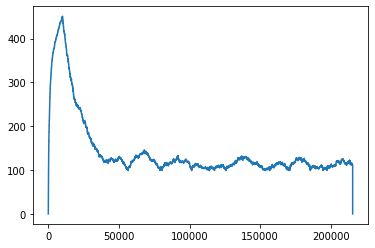

In [40]:
plt.plot(sample["windowed_sample_size"])

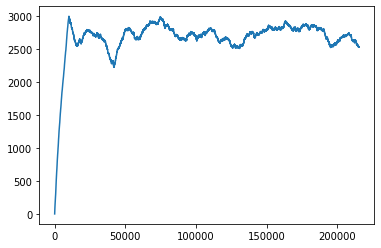

In [41]:
plt.plot(sample["windowed_cardinality"])

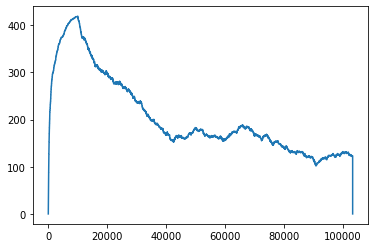

In [ ]:
plt.plot(sample2["windowed_sample_size"])

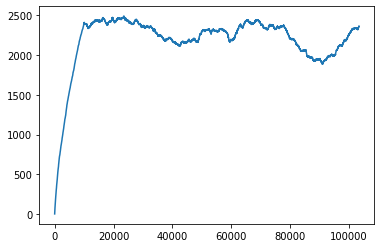

In [ ]:
plt.plot(sample2["windowed_cardinality"])

In [ ]:
TOTAL_number_of_tokens_without_e = len([
    token
    for token in mobydick_tokens
    if "e" not in token
])

SAMPLE_number_of_tokens_without_e = len([
    token
    for token in sample["sample"].keys()
    if "e" not in token
])

(
    TOTAL_number_of_tokens_without_e,
    SAMPLE_number_of_tokens_without_e,
    SAMPLE_number_of_tokens_without_e / sample["sampleSize"] * sample["cardinality"]["af-kmv"]
)

In [ ]:
TOTAL_number_of_tokens_without_e = len([
    token
    for token in set(mobydick_tokens)
    if "e" not in token
])

SAMPLE_number_of_tokens_without_e = len([
    token
    for token in sample["sample"].keys()
    if "e" not in token
])

(
    TOTAL_number_of_tokens_without_e,
    SAMPLE_number_of_tokens_without_e,
    SAMPLE_number_of_tokens_without_e / sample["sampleSize"] * sample["cardinality"]["af-kmv"]
)

In [ ]:
import collections

TOTAL_number_of_distinct_mice = len([
    token
    for (token, count) in collections.Counter(mobydick_tokens).items()
    if count <= 5
])

SAMPLE_number_of_distinct_mice = len([
    token
    for (token, count) in sample["sample"].items()
    if count <= 5
])

(
    TOTAL_number_of_distinct_mice,
    SAMPLE_number_of_distinct_mice,
    SAMPLE_number_of_distinct_mice / sample["sampleSize"] * sample["cardinality"]["af-kmv"]
)

In [ ]:
TOTAL_number_of_mice = len([
    token
    for token, count in mobydick_tokens.items()
    if "e" not in token
])

SAMPLE_number_of_tokens_without_e = len([
    token
    for token in sample["sample"].keys()
    if "e" not in token
])

(
    TOTAL_number_of_tokens_without_e,
    SAMPLE_number_of_tokens_without_e,
    SAMPLE_number_of_tokens_without_e / sample["sampleSize"] * sample["cardinality"]["af-kmv"]
)